In [1]:
import nltk
nltk.download('brown')
from nltk.corpus import brown

[nltk_data] Downloading package brown to /Users/mine/nltk_data...
[nltk_data]   Package brown is already up-to-date!


In [8]:
sentences = brown.sents()
s_list = []
for i, sent in enumerate(sentences):
    s_list.append(sent)
print(s_list[1])
for i, line in enumerate(s_list):
    s_list[i].append("/s")

for i, line in enumerate(s_list):
    x = ["<s>"]
    s_list[i] = x + s_list[i]

['The', 'jury', 'further', 'said', 'in', 'term-end', 'presentments', 'that', 'the', 'City', 'Executive', 'Committee', ',', 'which', 'had', 'over-all', 'charge', 'of', 'the', 'election', ',', '``', 'deserves', 'the', 'praise', 'and', 'thanks', 'of', 'the', 'City', 'of', 'Atlanta', "''", 'for', 'the', 'manner', 'in', 'which', 'the', 'election', 'was', 'conducted', '.']


['The',
 'jury',
 'further',
 'said',
 'in',
 'term-end',
 'presentments',
 'that',
 'the',
 'City',
 'Executive',
 'Committee',
 ',',
 'which',
 'had',
 'over-all',
 'charge',
 'of',
 'the',
 'election',
 ',',
 '``',
 'deserves',
 'the',
 'praise',
 'and',
 'thanks',
 'of',
 'the',
 'City',
 'of',
 'Atlanta',
 "''",
 'for',
 'the',
 'manner',
 'in',
 'which',
 'the',
 'election',
 'was',
 'conducted',
 '.']

In [4]:
#Divided data 
trn_data = s_list[:int(0.7*len(sentences))] 
dev_data = s_list[int(0.7*len(sentences)):int(0.8*len(sentences))]
tst_data = s_list[int(0.8*len(sentences)):]

print(len(trn_data))
print(len(dev_data))
print(len(tst_data))

40138
5734
11468


In [5]:
#getting the vocabsize
def vocabsize (data):
    size = 0
    vocab = []
    for sent in data:
        for word in sent:
            if word not in vocab:
                vocab.append(word)
                size=size+1
    return  size

In [6]:
trn_data_vocabsize = vocabsize (trn_data)
dev_data_vocabsize = vocabsize (dev_data)
tst_data_vocabsize = vocabsize (tst_data)

In [7]:
print(trn_data_vocabsize)

49209


#a)
#Write a code that learns vanilla unigram and bigram models on the training data as Python dictionaries. Report the perplexity of your unigram and bigram models on the training data.

In [8]:


import io, sys, math, re
from collections import defaultdict
import numpy as np


In [9]:
#building the n gram model

def build_ngram(data, n):

    total_number_words = 0
    counts = defaultdict(lambda: defaultdict(lambda: 0.0))

    for sentence in data:
        sentence = tuple(sentence)

        for i in range(len(sentence)):
            total_number_words +=1
            for k in range(n):
                if i-k < 0:
                    break
                counts[sentence[i-k:i]][sentence[i]] +=1 
                           

    proba  = defaultdict(lambda: defaultdict(lambda: 0.0))

    for context in counts.keys():

        denom =0
        for w in counts[context].keys():
            denom += counts[context][w]
        for w in counts[context].keys():
            proba[context][w] = counts[context][w]/denom 
    
    return proba

In [10]:
n = 2
print("build ngram model with n = ", n)
model_unigram = build_ngram(trn_data, n)

build ngram model with n =  2


In [11]:
def get_prob(model, context, w):
   #if context in model and w in model[context]:
        return model[context][w]

In [12]:
def perplexity(model, data, n):
    perp, T = 0.0, 0
    for sentence in data:
        sentence = tuple(sentence)
        for i in range(1, len(sentence)):
            nc = min(n-1, i)
            context = sentence[i-nc:i]
            perp += -math.log(get_prob(model, context, sentence[i]))
            T += 1
    perp = math.exp(perp/T)
    return perp

In [13]:
print("Unigram model perplexity:", perplexity(model_unigram, trn_data, n=1))

Unigram model perplexity: 1208.3057291645355


In [14]:
#for the bigram model
n = 2
print("build ngram model with n = ", n)
model_bigram = build_ngram(trn_data, n)
print("bigram model perplexity:", perplexity(model_bigram, trn_data, n=n))

build ngram model with n =  2
bigram model perplexity: 64.0904088784753


#(b) Implement add-λ smoothing method. With varying λ values, try to draw a similar curve to P2-(d). You should measure the perplexity on the developing data.

In [16]:
def build_ngram_smoothing(data, n,k):

    total_number_words = 0
    counts = defaultdict(lambda: defaultdict(lambda: 0.0))

    for sentence in data:

        sentence = tuple(sentence)

        for i in range(len(sentence)):
            total_number_words +=1
            for k in range(n):
                if i-k < 0:
                    break
                counts[sentence[i-k:i]][sentence[i]] +=1 
                           

    proba  = defaultdict(lambda: defaultdict(lambda: 0.0))

    for context in counts.keys():

        denom =0
        for w in counts[context].keys():
            denom += counts[context][w]
        for w in counts[context].keys():
            proba[context][w] = ((counts[context][w])+k)/(denom+k*trn_data_vocabsize) 
    
    return proba , counts #(denom+k*trn_data_vocabsize)

In [17]:
def get_prob_smoothing(model, context, w,k,count_dict):
    denom = 0
    if context in model and w in model[context]: 
        return model[context][w]
    elif context in model and w not in model[context]:
        value=dict(count_dict[context].items())
        denom = sum(value.values())
        return 1/(denom+trn_data_vocabsize*k)      
    else:
        return 1/(trn_data_vocabsize*k)

In [19]:
def perplexity_smooth(model, data, n, k,count_dict):
    perp, T = 0.0, 0
    for sentence in data:
        sentence = tuple(sentence)
        for i in range(1, len(sentence)):
            nc = min(n-1, i)
            context = sentence[i-nc:i]
            perp += -math.log(get_prob_smoothing(model, context, sentence[i],k,count_dict))
            T += 1
    perp = math.exp(perp/T)
    return perp

In [20]:
n = 2
print("build ngram model with n = ", n)
model_bigram_smooth , count = build_ngram_smoothing(trn_data, n,1/1000)
print("bigram model perplexity:", perplexity_smooth(model_bigram_smooth, dev_data, n=n,k=1/1000, count_dict=count))

build ngram model with n =  2
bigram model perplexity: 772.8821599919268


In [21]:
def best_lambda(n,k,data):
  model_smooth , count = build_ngram_smoothing(trn_data, n , k)
  return perplexity_smooth(model_smooth, data, n=n,k=k, count_dict=count)

In [22]:
#find the best lamnda for bigram
perp=[]
k_list=[]
k=1
for i in range (50):
  k_list.append(k) 
  perp.append(best_lambda(n=2,k=k,data=dev_data))
  k=k/10

minimum lambda 1.0000000000000003e-49
minimum perplexity 11.86377361429119


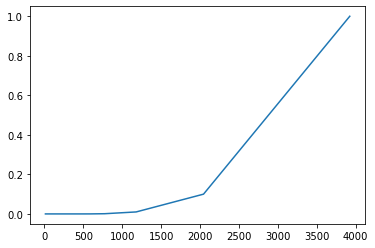

In [23]:
import matplotlib.pyplot as plt
plt.plot(perp,k_list)
print('minimum lambda',min(k_list))
print('minimum perplexity',min(perp))

minimum lambda 1.0000000000000003e-49
minimum perplexity 1130.109629009069


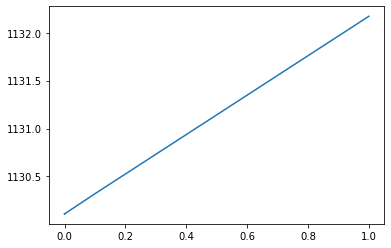

In [24]:
#for unigram
perp_uni=[]
k_list_uni=[]
k=1
for i in range (50):
  k_list_uni.append(k) 
  perp_uni.append(best_lambda(n=1,k=k,data=dev_data))
  k=k/10
plt.plot(k_list_uni,perp_uni)
print('minimum lambda',min(k_list_uni))
print('minimum perplexity',min(perp_uni))

#(c) Pick the best λ value and train again your unigram and bigram models on training data + developing data. Report new perplexity of your unigram and bigram models on the test data.


In [25]:
#combining train and development data 
trn_data_1 = s_list[:int(0.8*len(sentences))] 
tst_data_1 = s_list[int(0.8*len(sentences)):]

In [26]:
#unigram
n = 1
print("build ngram model with n = ", n)
model_bigram_smooth_1 , count = build_ngram_smoothing(trn_data_1, n,1.0000000000000003e-49)
print("bigram model perplexity:", perplexity_smooth(model_bigram_smooth_1, tst_data_1, n=1,k=1.0000000000000003e-49, count_dict=count))

build ngram model with n =  1
bigram model perplexity: 1076.4890760988549


In [27]:
#bigram
n = 2
print("build ngram model with n = ", n)
model_bigram_smooth_2 , count = build_ngram_smoothing(trn_data_1, n , 1.0000000000000003e-49)
print("bigram model perplexity:", perplexity_smooth(model_bigram_smooth_2, tst_data_1, n=2,k=1.0000000000000003e-49, count_dict=count))

build ngram model with n =  2
bigram model perplexity: 11.636096923688147


# (d) Generate random sentences based on the unigram and bigram language models from part (c). Report 5 sentences per model by sampling words from each model continuously until meeting the stop symbol ⟨/s⟩.

In [28]:
def get_proba_distrib(model, context):
    
    if context in model:
        return model[context]
    else:
        return get_proba_distrib(model, context[1:])

In [29]:
def generate(model):
    sentence = ["<s>"]
    while sentence[-1] != "/s" and len(sentence)<20:
        proba = get_proba_distrib(model, tuple(sentence))
        w = np.random.choice((list(proba.keys())), 1)
        sentence.append(w[0])
    return sentence

In [30]:
#from unigram 
print("Results from unigram")
print("Generated sentence: ",generate(model_bigram_smooth_1))
print("Generated sentence: ",generate(model_bigram_smooth_1))
print("Generated sentence: ",generate(model_bigram_smooth_1))
print("Generated sentence: ",generate(model_bigram_smooth_1))
print("Generated sentence: ",generate(model_bigram_smooth_1))

Results from unigram
Generated sentence:  ['<s>', 'McElyee', 'Gigenza', 'archbishop', 'blood-flow', 'threads', 'Meir', 'catalytic', 'Adirondack', 'freight', 'Evelyn', '7599', 'supermachine', 'uppermost', 'paved', 'Westchester', 'powerfulness', 'Fury', 'tirades', 'Gazettes']
Generated sentence:  ['<s>', 'Kreisler', 'Screvane', 'dusty-green', 'Nineteenth-century', 'was', 'applications', 'borrowed', 'wink', 'censuses', 'loose-leaf', 'offspring', 'sum', 'seeks', 'tyranny', 'condiments', 'McNeill', 'exhaled', 'bevel', 'fella']
Generated sentence:  ['<s>', 'acid-fast', 'taxi-ways', 'impudently', 'regard', 'oxyhydroxides', 'Jarrodsville', 'lice', 'Idaho', 'rightfully', 'parasites', 'custodian', 'Catholic', 'hunts', 'Adriatic', 'impudent', 'Cherry', 'KCs', 'forcibly', 'lemmas']
Generated sentence:  ['<s>', 'pronouncement', 'flaunting', 'Vision', 'pleads', 'tribes', 'Timmy', 'Telegraph', 'cross-fertilized', 'Talleyrand', 'Milk', 'greenware', 'paterollers', 'heroin', 'mollify', 'improvising', 'd

In [211]:
#from bigram
print("Results from bigram")
print("Generated sentence: ",generate(model_bigram_smooth_2))
print("Generated sentence: ",generate(model_bigram_smooth_2))
print("Generated sentence: ",generate(model_bigram_smooth_2))
print("Generated sentence: ",generate(model_bigram_smooth_2))
print("Generated sentence: ",generate(model_bigram_smooth_2))

Results from bigram
Generated sentence:  ['<s>', 'Boatyards', 'which', 'Divine', 'Being', 'somewhat', 'crazy', 'on', 'natural', 'fruits', 'once', 'whole', 'grain', 'at', 'McNeil', 'Island', 'Sound', '.', '/s']
Generated sentence:  ['<s>', 'Chromatography', '.', '/s']
Generated sentence:  ['<s>', 'Straight', 'vertical', 'position', 'within', 'sought', '``', 'confessing', 'that', "Faulkner's", 'total', 'war', 'against', 'submarine', 'elements', 'only', 'fully', 'explored', 'every', 'link']
Generated sentence:  ['<s>', 'Acey', 'Squire', 'chewed', ',', 'straight', 'toward', 'that', 'moved', 'offices', '--', 'through', 'Hanover', ',', 'unhappy', 'and', 'glided', 'lower', 'through', 'Christopher']
Generated sentence:  ['<s>', 'Electronics', 'Center', 'last', 'passable', ',', 'answering', '.', '/s']


#(e) Choose at least one additional extension to implement. The available options are trigram, Good-Turing smoothing, interpolation method, and creative handling of unknown words. Verify whether some of your extensions could improve 1) perplexity on test data and 2) your random sentence generation in part (d).

In [ ]:
#we are using trigram and see if it improves

minimum lambda 1.0000000000000003e-49
minimum perplexity 2.6547998954244014e-13


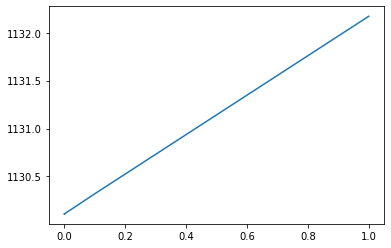

In [214]:
#getting the best parmeter for trigram
perp_uni_3=[]
k_list_uni_3=[]
k=1
for i in range (50):
  k_list_uni_3.append(k) 
  perp_uni_3.append(best_lambda(n=3,k=k,data=dev_data))
  k=k/10
plt.plot(k_list_uni,perp_uni)
print('minimum lambda',min(k_list_uni_3))
print('minimum perplexity',min(perp_uni_3))

In [227]:
n = 3
print("build ngram model with n = ", n)
model_bigram_smooth_3 , count = build_ngram_smoothing(trn_data_1, n , 1.0000000000000003e-49)
print("Trigram model perplexity:", perplexity_smooth(model_bigram_smooth_3, tst_data_1, n=3,k=1.0000000000000003e-49, count_dict=count))
#the preplexity for trigram decreased significantly compared to the bigram 

build ngram model with n =  3
Trigram model perplexity: 2.182609485477493e-12


In [230]:
#from trigram
print("Results from bigram")
print("Generated sentence: ",generate(model_bigram_smooth_3))
print("Generated sentence: ",generate(model_bigram_smooth_3))
print("Generated sentence: ",generate(model_bigram_smooth_3))
print("Generated sentence: ",generate(model_bigram_smooth_3))
print("Generated sentence: ",generate(model_bigram_smooth_3))

Results from bigram
Generated sentence:  ['<s>', 'Orchesis', ',', 'Golf', 'Club', 'shouting', ',', 'possession', 'of', 'guilty', 'knowledge', '.', '/s']
Generated sentence:  ['<s>', 'Install', 'your', 'disappearing', 'stair', '(', 'or', 'wales', 'and', 'courses', 'for', 'knitted', 'fabrics', ')', 'are', 'not', 'one', 'we', 'would', 'ever']
Generated sentence:  ['<s>', 'Corollary', '.', '/s']
Generated sentence:  ['<s>', 'Olgivanna', '--', 'in', 'contradistinction', 'to', 'gentile', 'factory', 'workers', '--', '``', 'found', 'such', 'favor', 'with', 'the', 'interplay', 'of', 'competitive', 'forces']
Generated sentence:  ['<s>', 'Unconcerned', 'with', 'the', 'First', 'Emperor', ',', 'Shih', 'Huang-ti', ',', 'in', 'circumstances', 'to', 'trust', 'Him', 'even', 'though', 'her', 'husband', 'through']
